# CGMD simulation of PEO

**`By You-Liang Zhu`**

## Introduction

This tutorial provides an introduction of general coarse-grained molecular dynamics (CGMD) simulation using GALAMOST. It is designed for new users who want to learn about how to run CGMD simulations. It does however assume that you have a machine with [MagiC-3.0](http://www.fos.su.se/~sasha/mdynamix/) and [GALAMOST](http://galamost.ciac.jl.cn/) correctly installed.

**Download [running files](https://bitbucket.org/galamostdevelopergroup/source-code/src/master/examples/Case12-CGMD-PEO/)**.

In this tutorial, we would like to make a system consisting of polyethylene oxide (PEO) dissolved in water. The system consists of 10 PEO_10 chains. MagiC software is employed to compute effective potentials by iterative Boltzmann Inversion or Inverse Monte Carlo method for the coarse-grained model. Then, GALAMOST is employed to efficiently run CGMD simulations.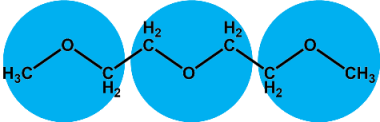

## Generating CG force field by MagiC 

Our goal here is to obtain a CG force field for PEO, treating the water implicitly by effective potentials. We will do this in a step-by-step way, showing how to use MagiC in easy and convenient way.

Requiring four files:
1. md_nowater.xtc - all-atom simulation trajectory file
2. md.tpr - the all-atom simulation running file of GROMACS
3. cgtraj.inp - bead mapping scheme file
4. rdf.inp - settings for the RDF-calculation
5. magic.inp - settings for few consequent runs of the inverse solver 

File "cgtraj.inp":

In [ ]:
&TRAJ
 NFORM='XTC',
 FNAME='md_nowater.xtc',
 NTYPES=1,
 NAMOL='Other_chain_A'
 NSPEC=10,
 NFBEG=1,
 NFEND=1,
 ISTEP=1,
 IPRINT=5,
&END

BeadMapping
CGTrajectoryOutputFile:peo10-10.xtc
 CGMolecularType:peo10-10.CG
  ParentType:peo
  PEB:    8:1-8
  PEO1:   7:9-15
  PEO2:   7:16-22
  PEO3:   7:23-29
  PEO4:   7:30-36
  PEO5:   7:37-43
  PEO6:   7:44-50
  PEO7:   7:51-57
  PEO8:   7:58-64
  PEC:    8:65-72
 EndCGMolecularType
EndBeadMappingRINT=5,
&END

File "rdf.inp":

In [ ]:
&Parameters
  TrajFile=peo10-10.xtc
  NMType=1
  NameMType= peo10-10.CG
  NMolMType= 10
  NPairBondsExclude  = 1
  NAngleBondsExclude = 1
  Exclusions = exclusions_SR.dat
  OutputFile= peo10-10.rdf
  Step = 1
  RMaxNB=20.
  RMinB=0.0
  RMaxB=20.
  ResolNB=0.1,
  ResolB=0.02,
  ResolA=1.0
&EndParameters

&CGTypes
PEB:PEB
PEO:PEO1 PEO2 PEO3 PEO4 PEO5 PEO6 PEO7 PEO8
PEC:PEC
&EndCGTypes

&RDFsNB
 add : all
&EndRDFsNB

&RDFsB
 add : peo10-10.CG : 1 : PEB  PEO1
 add : peo10-10.CG : 2 : PEO1 PEO2,PEO2 PEO3,PEO3 PEO4,PEO4 PEO5,PEO5 PEO6,PEO6 PEO7,PEO7 PEO8
 add : peo10-10.CG : 3 : PEO8 PEC
&EndRDFsB

&RDFsA
add : peo10-10.CG : 4: PEB PEO1 PEO2
add : peo10-10.CG : 5: PEO1 PEO2 PEO3,PEO2 PEO3 PEO4,PEO3 PEO4 PEO5,PEO4 PEO5 PEO6,PEO5 PEO6 PEO7,PEO6 PEO7 PEO8
add : peo10-10.CG : 6: PEO7 PEO8 PEC
&EndRDFsA

File "magic.inp":

In [ ]:
  NMType = 1
  NameMType = peo10-10.CG
  NMolMType = 10
  LMoveMType = TRUE,
  Box = 78.55459, 78.55459, 78.55459
  Epsilon = 1.0
  TEMP=300.
  ExclusionSR = exclusions_SR.dat
  ExclusionEL = exclusions_SR.dat
  MCSteps = 50000000,
  MCStepsEquil = 2500000,
  MCStepAtom = 1.0
  MCStepTransMol = 0.7
  MCStepRotMol = 0.01
  iMCStepTransMol = 500
  iMCStepRotMol = 500
  NMCAutoAdjust=10
  iCalcEnergy = 100000
  RCutEl=20.0
  AF = 3.0
  FQ = 9.0
  ProhibPotLevel=1000.0
  RandomSeed=51

  InverseMode =NG 
  NIter=10
  IAverage=500
  REGP = 0.3,
  MaxPotCor=2.0
  KeepStructure=False
  MaxRelDif=10.0
  iPotCorCheck = 0

  VerboseLevel=5
  InputRDF= peo10-10.rdf
! Input file with tabulated Potentials
! InputPot=00.peo10-10.i000.pot
 
  Output = 01.peo10-10
  DumpLastConf = .false.
  WriteTraj = 0

### 1. Extraction of molecular topology mmol files out of the .tpr file:

Required: md.tpr

File "mmol.py":

In [ ]:
#!/usr/bin/python 
import MagicTools as MT # Import MagicTools Library and set location for the tutorial root-folder
MT.tpr2mmol('md.tpr')

This will result in 2 new files: Other_chain_A.mmol, SOL.mmol

### 2. Bead mapping:

Required: cgtraj.inp, md_nowater.xtc

In [ ]:
cgtraj cgtraj.inp

This will generate a bunch of new files:
1. peo10-10.xtc - BeadMapped trajectory
2. last_frame.xmol - last frame of the BeadMapped trajectroy in a human-readable format XMOL. It has atom names and is useful when you open the XTC-trajecory by VMD
3. peo10-10.CG.mmol - BeadMapped representation of the original molecules.

### 3. RDF calculation

Required files: peo10-10.xtc, peo10-10.CG.mmol

In [ ]:
rdf.py -i rdf.inp

This will generate a bunch of new files:
1. peo10-10.rdf - File with reference RDFs
2. peo10-10.CG.mcm, - Molecular Topology files, storing information about atoms of the molecule, atom-types and bond (pairwise and angle-bending)
3. exclusions_SR.dat - file listing atoms excluded from non-bonded interctions (RDFs)

### 3. Inverse Monte Carlo

Required files:
1. peo10-10.CG.mcm
2. peo10-10.rdf - This is similar set of reference RDFs but calculated over longer trajectory.
3. exclusions_SR.dat - Exclusions specifications. Note that for Cholecterol we suppressed all intramolecular short-range interactions.
4. magic.inp - settings for few consequent runs of the inverse solver (Magic Core)

In [ ]:
magic-gfortran magic.inp > magic.out

This will generate a bunch of new files: magic.out, and \*.pot  

### 4. Extraction of GALAMOST files

Required：
1. magic.inp, start.xmol
2. 03.peo10-10.i010.pot - Resulting effective potentials from the IMC
3. peo10-10.CG.mcm,  - molecular topology

In [ ]:
system = MT.GALAMOSTTopology(inpMagiC='magic.inp', xmol='start.xmol',eps=78.0)

This will generate a bunch of new files:
1. topology.xml - topology in XML format (can be viewed by vmd: vmd -hoomd topology.xml)
2. tables.inc.py - python script defining where the tabulated potentials are stored
3. exclusionsSL.inc.py and exclusionsEL.inc.py - python script describing short-range and electrostatic exclusions in the system

## Prepare GALA file

GALA script "galajob.gala" that defines the program settings is given as following for CGMD run.

In [ ]:
#!/usr/bin/python
import sys
import os
sys.path.append('/home/msm/soft/galamost3/lib') # the path where the GALAMOST program is installed
import galamost
from optparse import OptionParser

global _options
parser = OptionParser()
parser.add_option('--gpu', dest='gpu', help='GPU on which to execute')
(_options, args) = parser.parse_args()


filename = 'topology.xml'# initial configuration file
build_method = galamost.XmlReader(filename) #
perform_config = galamost.PerformConfig(0)# assign GPU by index
all_info = galamost.AllInfo(build_method, perform_config)# build system information

dt = 0.002  # timestep in ps
rcut = 1.5  # real-space cutoff in nm
rbuffer =0.1 # buffer-size (nm) for neighbour list
k_pme_mesh = 48
exclusionsSR='exclusionsSR.inc.py' # python script defining short-range exclusions
exclusionsEL='exclusionsEL.inc.py' # python script defining electrostatic exclusions
app = galamost.Application(all_info, dt)# build up an application with system information and integration time-step
npoints_in_table = 1501 # Number of points in potential table

if npoints_in_table is None:
    raise ValueError('Value for number of points in the tabulated potential is not stated!!!')
# execute python scripts with exclusion definitions
exec(compile(source=open(exclusionsSR).read(), filename=exclusionsSR, mode='exec'))
exec(compile(source=open(exclusionsEL).read(), filename=exclusionsEL, mode='exec'))
# execute python script with tablulated potentials settings
exec(compile(source=open('tables.inc.py').read(), filename='tables.inc.py', mode='exec'))

group = galamost.ParticleSet(all_info, "all")# Collection of all atoms in the system

comp_info = galamost.ComputeInfo(all_info, group)  # calculating system informations, such as temperature, pressure, and momentum
Temperature = 303.0*0.00831  #kT  k=0.00831 kJ/mol

Bd = galamost.BdNvt(all_info, group, Temperature, 123)# Set Langevin dynamics
Bd.setGamma(5.0)#(,gamma)
app.add(Bd)

ZeroMomentum = galamost.ZeroMomentum(all_info) # removing the momentum of the center of mass
ZeroMomentum.setPeriod(10000)# (period)
app.add(ZeroMomentum)

DInfo = galamost.DumpInfo(all_info, comp_info, 'data.log')# output system informations, such as temperature, pressure, and momentum
DInfo.setPeriod(1000)# (period)
app.add(DInfo)

dcd = galamost.DcdDump(all_info, 'trj',True) # write trajectory in dcd format
dcd.setPeriod(500)# (how often to write frames) 1ps
dcd.unwrap(True)
app.add(dcd)

#ready ro run 
app.run (5000000)#(the number of steps to run)
neighbor_listSR.printStats()# output the information about neighbor_list 

### Run simulaiton

Required: galajob.gala, topology.xml, exclusionsSR.inc.py, exclusionsEL.inc.py, tables.inc.py

In [ ]:
python galajob.gala --gpu=0 >a.log&

[OVITO](http://www.ovito.org/) is suggested to render the pictures of system snapshots with the output XML files

For further calculation of properties, GALAMOST plugin [`galaTackle`](https://galamost.readthedocs.io/en/latest/galatackle.html) can be used, which can be find in `galamost installed path\bin`.

In [ ]:
galaTackle *.xml
1
enter